### Necessary Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
import sys
import os
import optuna
sys.path.append('../..')
from definitions import *
from src.datasets.isic import __cols__ as isic_cols
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,recall_score,roc_curve
from src.utils import score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import GroupKFold,KFold
from sklearn.impute import KNNImputer,MissingIndicator,SimpleImputer

### Reproducibility

In [2]:
SEED = 1

### Data Loading

In [3]:
df = pd.read_csv(os.path.join(ISIS_2024_DIR, 'metadata.csv'))
df = df[isic_cols + ['target','split','patient_id']]
patient_id = df['patient_id'][df['split'] == 'train']
df = df.drop(columns=['patient_id'])
df.head()

,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,target,split
0,60.0,male,lower extremity,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,...,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,0,train
1,60.0,male,head/neck,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,...,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,0,train
2,60.0,male,posterior torso,3.40,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,...,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,0,train
3,65.0,male,anterior torso,3.22,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,...,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,0,train
4,55.0,male,anterior torso,2.73,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,...,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,0,train


In [4]:
train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'val']

X_train = train_df.drop(columns=['target','split'])
y_train = train_df['target']

X_val = val_df.drop(columns=['target','split'])
y_val = val_df['target']

### Preprocessing

In [5]:
preprocessor = Pipeline([
    # ("onehot",ColumnTransformer(transformers=[
    #     ('onehot', OneHotEncoder(sparse_output=False,handle_unknown="ignore",drop="first"), X_train.select_dtypes(include='object').columns),
    # ], remainder='passthrough')),
    # ('impute', KNNImputer(n_neighbors=5))
    ("onehot",ColumnTransformer(transformers=[
       ('onehot', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), X_train.select_dtypes(include='object').columns),
    ], remainder='passthrough')),
])

In [6]:
X_train = preprocessor.fit_transform(X_train)

In [7]:
X_val = preprocessor.transform(X_val)

### Training a baseline model

In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [9]:
params = {
    "n_estimators" : 100,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.1,
    "max_depth": 6,
    "subsample": 0.5,
    "colsample_bytree": 0.5,
    "verbosity": 0,
    "seed": SEED,
    "device": "gpu",
}

In [10]:
booster = xgb.train(params, dtrain)

In [11]:
y_hat = booster.predict(dval)
y_hard = np.int32(y_hat > 0.5)

In [12]:
def calc_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
    }

In [13]:
calc_metrics(y_val, y_hard)

{'accuracy': 0.9991322950795147, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}

<Axes: >

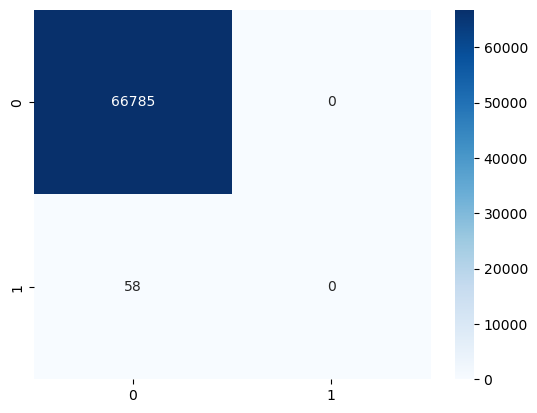

In [14]:
cm = confusion_matrix(y_val, y_hard)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [15]:
score(y_val, y_hat)

0.14216779010360053

### Hyperparameter tuning

In [16]:
top_k_best_params = {}
k = 5

In [17]:
def objective(trail : optuna.Trial):

    params = {
        "seed" : SEED,
        "device" : "gpu",
        "verbosity" : 0,
    }

    params["n_estimators"] = trail.suggest_int("n_estimators", 50, 1000)

    params["objective"] = "binary:logistic"

    params["eval_metric"] = "logloss"

    params["eta"] = trail.suggest_float("eta", 0.01, 0.3)

    params["max_depth"] = trail.suggest_int("max_depth", 3, 12)

    params["subsample"] = trail.suggest_float("subsample", 0.5, 1.0)

    params["colsample_bytree"] = trail.suggest_float("colsample_bytree", 0.5, 1.0)

    params["scale_pos_weight"] = trail.suggest_float("scale_pos_weight", 1.0, 1200.0)

    params["min_child_weight"] = trail.suggest_int("min_child_weight", 1, 300)

    booster = xgb.train(params, dtrain)

    y_hat = booster.predict(dval)

    value = score(y_val, y_hat)

    if len(top_k_best_params) < k:
        top_k_best_params[value] = {**params,"score":value}
    else:
        min_value = min(top_k_best_params.keys())
        if value > min_value:
            del top_k_best_params[min_value]
            top_k_best_params[value] = {**params,"score":value}

    return value

In [18]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))

[I 2024-07-12 21:46:34,279] A new study created in memory with name: no-name-c1484302-abb3-470f-8072-858dc671cfdc


In [19]:
study.optimize(objective, n_trials=2000, show_progress_bar=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

[I 2024-07-12 21:46:34,395] Trial 0 finished with value: 0.15956834721817048 and parameters: {'n_estimators': 446, 'eta': 0.21889410309822585, 'max_depth': 3, 'subsample': 0.6511662863159199, 'colsample_bytree': 0.5733779454085566, 'scale_pos_weight': 111.71397512778856, 'min_child_weight': 56}. Best is trial 0 with value: 0.15956834721817048.
[I 2024-07-12 21:46:34,518] Trial 1 finished with value: 0.16358995541534463 and parameters: {'n_estimators': 378, 'eta': 0.12506256752689426, 'max_depth': 8, 'subsample': 0.7095972572016473, 'colsample_bytree': 0.8426097501983798, 'scale_pos_weight': 246.13824742808941, 'min_child_weight': 264}. Best is trial 1 with value: 0.16358995541534463.
[I 2024-07-12 21:46:34,631] Trial 2 finished with value: 0.1478838423866602 and parameters: {'n_estimators': 76, 'eta': 0.20443557795173664, 'max_depth': 7, 'subsample': 0.7793449142228759, 'colsample_bytree': 0.5701934692976169, 'scale_pos_weight': 238.52368541276968, 'min_child_weight': 241}. Best is tri

In [20]:
best_params = {
    "seed" : SEED,
    "device" : "gpu",
    "verbosity" : 0,
    "objective" : "binary:logistic",
    **study.best_params
}

In [21]:
best_params

{'seed': 1,
 'device': 'gpu',
 'verbosity': 0,
 'objective': 'binary:logistic',
 'n_estimators': 896,
 'eta': 0.27752630420551405,
 'max_depth': 4,
 'subsample': 0.9398610717506904,
 'colsample_bytree': 0.8159974752315686,
 'scale_pos_weight': 253.54318592414413,
 'min_child_weight': 104}

In [22]:
model = xgb.train(best_params, dtrain)

In [23]:
y_hat = model.predict(dval)
y_hard = np.int32(y_hat > 0.5)

In [24]:
calc_metrics(y_val, y_hard)

{'accuracy': 0.9685980581362297,
 'f1': 0.033164440350069095,
 'precision': 0.017037387600567912,
 'recall': 0.6206896551724138}

<Axes: >

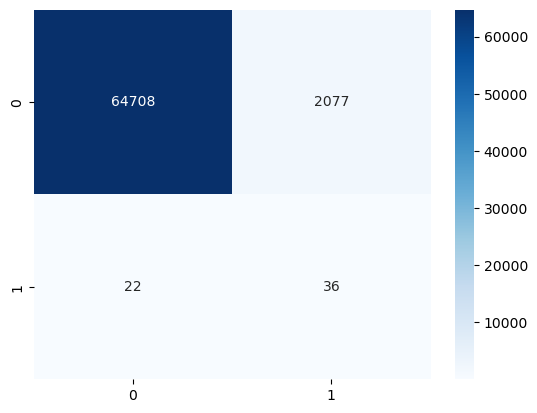

In [25]:
cm = confusion_matrix(y_val, y_hard)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [26]:
score(y_val, y_hat)

0.1691215506269475

In [27]:
def train_all(top_k_best_params : dict) -> dict[str,xgb.Booster]:

    models = {}

    for value in top_k_best_params.values():
        model = xgb.train({**best_params, **value}, dtrain)
        models[value["score"]] = model

    return models

In [28]:
def predict_all(models : dict[str,xgb.Booster], X_val : np.ndarray) -> np.ndarray:

    y_hat = np.zeros(X_val.shape[0])

    for model in models.values():
        y_hat += model.predict(xgb.DMatrix(X_val))

    y_hat /= len(models)

    return y_hat

In [29]:
models = train_all(top_k_best_params)

In [30]:
y_hat = predict_all(models, X_val)

In [31]:
calc_metrics(y_val, np.int32(y_hat > 0.5))

{'accuracy': 0.973564920784525,
 'f1': 0.037057220708446865,
 'precision': 0.019133370849746763,
 'recall': 0.5862068965517241}

<Axes: >

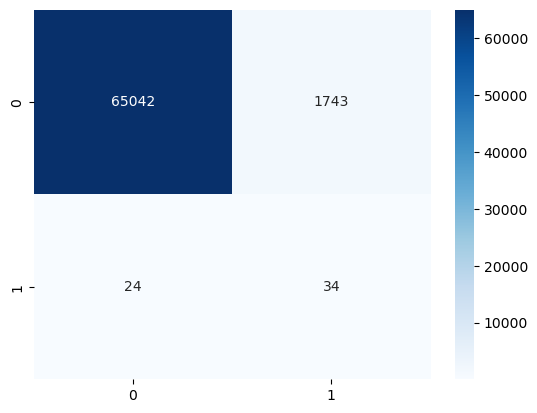

In [32]:
cm = confusion_matrix(y_val, np.int32(y_hat > 0.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [33]:
score(y_val, y_hat)

0.17299713697841498

#### Feature importance

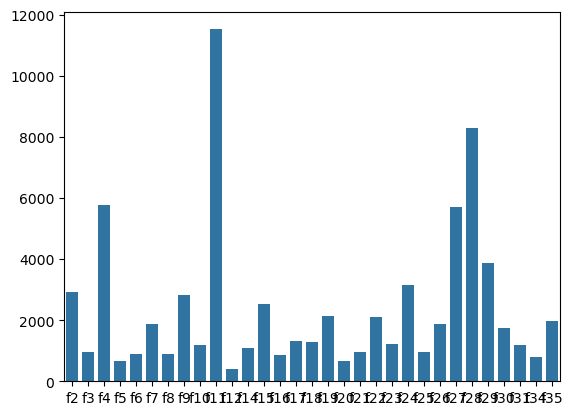

In [34]:
ax = sns.barplot(model.get_score(importance_type='gain'))

### Plots

<Axes: ylabel='Count'>

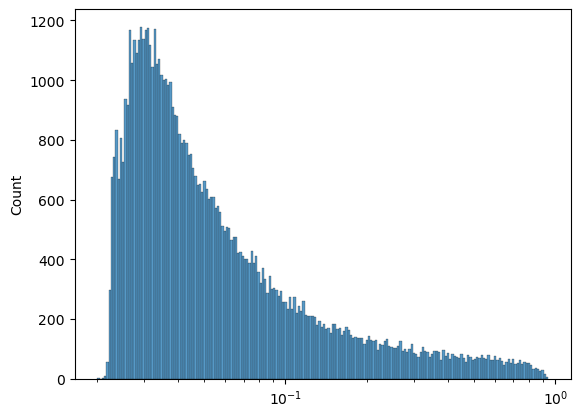

In [35]:
sns.histplot(y_hat, bins=200, log_scale=True)

In [36]:
def plot_roc_curve(models : dict[float, xgb.Booster], dval : xgb.DMatrix, y_val : np.ndarray):

    fig, ax = plt.subplots()

    mean = None

    for score, model in models.items():
        y_hat = model.predict(dval)
        mean = y_hat if mean is None else mean + y_hat
        fpr, tpr, _ = roc_curve(y_val, y_hat)
        ax.plot(fpr, tpr, label=f"{score:.4f}")

    mean /= len(models)

    fpr, tpr, _ = roc_curve(y_val, mean)
    ax.plot(fpr, tpr, label=f"Mean")

    ax.plot([0, 1], [0, 1], color='black', linestyle='--')

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    ax.legend(title="Score")

    ### Zoom in view of the upper left corner

    ax.set_xlim([0, 0.25])
    ax.set_ylim([0.75, 1])

    plt.show()

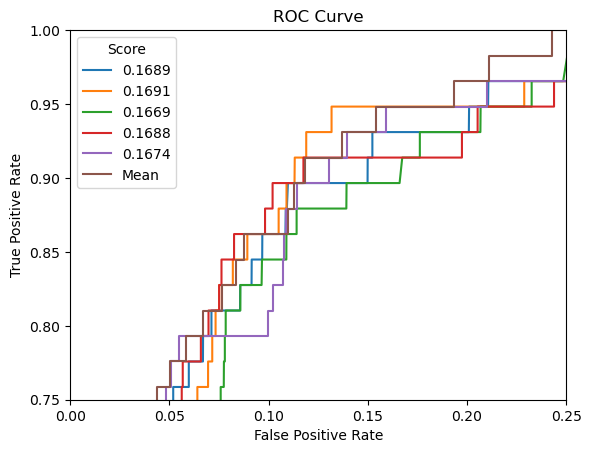

In [37]:
plot_roc_curve(models, dval, y_val)

In [38]:
optuna.visualization.plot_optimization_history(study)

In [39]:
optuna.visualization.plot_parallel_coordinate(study)

### Feature engeneering

In [40]:
def feature_engineering(df : pd.DataFrame):

    df = df.copy()
    eps = 1e-6

    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / (df["clin_size_long_diam_mm"] + eps)
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2 + eps)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / (df["tbp_lv_radial_color_std_max"] + eps)
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2)
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / (df["tbp_lv_areaMM2"] + eps)
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / (df["tbp_lv_Lext"] + eps)
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / (df["age_approx"] + eps)
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df["tbp_lv_y"], df["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    return df

In [41]:
train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'val']

X_train = train_df.drop(columns=['target','split'])
y_train = train_df['target']

X_val = val_df.drop(columns=['target','split'])
y_val = val_df['target']

In [42]:
X_train = feature_engineering(X_train)

In [45]:
preprocessor = Pipeline([
    # ("onehot",ColumnTransformer(transformers=[
    #     ('onehot', OneHotEncoder(sparse_output=False,handle_unknown="ignore",drop="first"), X_train.select_dtypes(include='object').columns),
    # ], remainder='passthrough')),
    # ('impute', KNNImputer(n_neighbors=5))
    ("onehot",ColumnTransformer(transformers=[
        ('onehot', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), X_train.select_dtypes(include='object').columns),
    ], remainder='passthrough')),
])

In [46]:
X_train = preprocessor.fit_transform(X_train)

In [47]:
X_val = feature_engineering(X_val)

In [48]:
X_val = preprocessor.transform(X_val)

In [49]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [50]:
top_k_best_params = {}

In [51]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))

[I 2024-07-12 21:51:35,479] A new study created in memory with name: no-name-1265c6a4-e68d-49e3-ace8-317298806dc3


In [52]:
study.optimize(objective, n_trials=2000, show_progress_bar=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

[I 2024-07-12 21:51:36,931] Trial 0 finished with value: 0.16871732502394451 and parameters: {'n_estimators': 446, 'eta': 0.21889410309822585, 'max_depth': 3, 'subsample': 0.6511662863159199, 'colsample_bytree': 0.5733779454085566, 'scale_pos_weight': 111.71397512778856, 'min_child_weight': 56}. Best is trial 0 with value: 0.16871732502394451.
[I 2024-07-12 21:51:37,080] Trial 1 finished with value: 0.14751843925308436 and parameters: {'n_estimators': 378, 'eta': 0.12506256752689426, 'max_depth': 8, 'subsample': 0.7095972572016473, 'colsample_bytree': 0.8426097501983798, 'scale_pos_weight': 246.13824742808941, 'min_child_weight': 264}. Best is trial 0 with value: 0.16871732502394451.
[I 2024-07-12 21:51:37,220] Trial 2 finished with value: 0.15009794683402472 and parameters: {'n_estimators': 76, 'eta': 0.20443557795173664, 'max_depth': 7, 'subsample': 0.7793449142228759, 'colsample_bytree': 0.5701934692976169, 'scale_pos_weight': 238.52368541276968, 'min_child_weight': 241}. Best is tr

In [53]:
best_params = {
    "seed" : SEED,
    "device" : "gpu",
    "verbosity" : 0,
    "objective" : "binary:logistic",
    **study.best_params
}

In [54]:
best_params

{'seed': 1,
 'device': 'gpu',
 'verbosity': 0,
 'objective': 'binary:logistic',
 'n_estimators': 861,
 'eta': 0.2890300241754803,
 'max_depth': 12,
 'subsample': 0.6388140011401287,
 'colsample_bytree': 0.7075035181923975,
 'scale_pos_weight': 870.2868512965088,
 'min_child_weight': 269}

In [57]:
top_k_best_params.keys()

dict_keys([0.17280524482836065, 0.17447333569121698, 0.17518144947889902, 0.17426156503241222, 0.1745090653744775])

In [55]:
model = xgb.train(best_params, dtrain)

In [56]:
y_hat = model.predict(dval)
y_hard = np.int32(y_hat > 0.5)

In [58]:
calc_metrics(y_val, y_hard)

{'accuracy': 0.9766018880062235,
 'f1': 0.045177045177045176,
 'precision': 0.02341772151898734,
 'recall': 0.6379310344827587}

<Axes: >

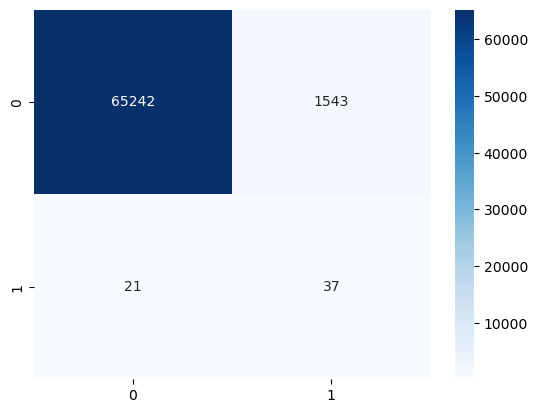

In [59]:
cm = confusion_matrix(y_val, y_hard)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [60]:
score(y_val, y_hat)

0.17518144947889902

In [61]:
models = train_all(top_k_best_params)

In [62]:
y_hat = predict_all(models, X_val)
y_hard = np.int32(y_hat > 0.5)

In [63]:
calc_metrics(y_val, y_hard)

{'accuracy': 0.9758089852340559,
 'f1': 0.04262877442273535,
 'precision': 0.022072348252605765,
 'recall': 0.6206896551724138}

<Axes: >

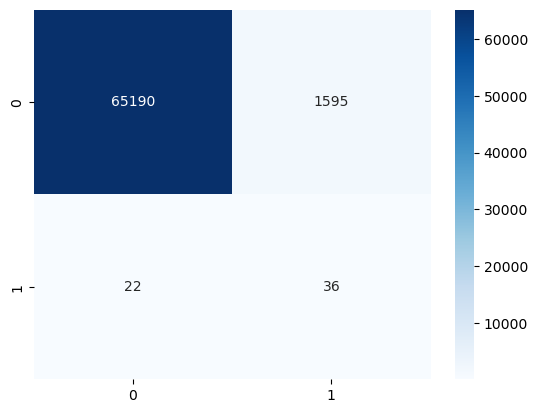

In [64]:
cm = confusion_matrix(y_val, y_hard)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [65]:
score(y_val, y_hat) 

0.17757012337583544